# Notebook que permite resolver el problema del Knapsack con valores asociados

En este Notebook se implementa el algoritmo que permite resolver el problema de la mochila, la idea es encontrar la configuración de objetos, cada uno asociado con un valor y un peso, que maximiza el valor total de los objetos seleccionados pero sin superar la capacidad C de la mochila.

Versiones:
- v1. Aprovechamiento de la sparsity del problema e implementación en GPU, sirve para resolver problemas donde cada objeto puede ser seleccionado i veces.
- v2. Aprovechamiento de la sparsity de los tensores generados teniendo en cuenta que solamente se forman dos diagonales no nulas, solo permite resolver el 0-1 knapsack
- v3. Limpieza del notebook
- v4. Generalización del método de sparsity en el caso de que cada objeto pueda ser seleccionado varias veces. <br>
   -v4.2. Esta versión es un desarrollo análogo a a la v4. pero sin aprovechar los cálculos intermedios.

- 
    

    


In [17]:
#Librerías
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from time import time
from scipy.sparse import diags

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Funciones de la tensor network

## Definimos los nodos de la tensor network:

In [18]:
def tensor_initial_generator(peso:int, valor:int, n_elementos:int, capacidad:int, previous_weight_solution:int)->np.array:
    """
    Genera el primer tensor en formato sparse de la cadena.
    Parameters:
    - peso (int): Peso del primer elemento.
    - valor (int): Valor del primer elemento.
    - n_elementos (int): numero de veces que se repite el primer elemento.
    - capacidad (int): capacidad limite de la mochila.
    - previous_weight_solution (int): peso que se pasa desde arriba.
    Returns:
    - tensor: representación sparse del primer tensor.
    - tensor.shape: dimensionalidad del tensor

    """
    tamaño_1 = min((capacidad-previous_weight_solution)//peso,n_elementos)+1
    tamaño_2 = min(capacidad, (tamaño_1-1)*peso+previous_weight_solution)+1
    tensor = np.zeros((tamaño_1,tamaño_2))
    for i in range(tamaño_1):
        elemento = i*peso + previous_weight_solution
        tensor[i][elemento] = valor**i
    
    return tensor,tensor.shape



def tensor_intermediate_generator(peso: int, n_elementos: int, capacidad: int, previous_weight: int) -> tuple[tuple[int], list[int]]:
    """
    Generador de los tensores intermedios, solamente se devuelven el número de elementos de cada diagonal no nula y la forma del tensor asociado.
    Parameters:
    - peso (int): Peso del elemento intermedio correspondiente.
    - n_elementos (int): numero de veces que se repite el elemento intermedio correspondiente.
    - capacidad (int): capacidad limite de la mochila.
    - previous_weight_solution (int): peso que se pasa desde arriba.
    Returns:
    - tensor.shape: dimensionalidad del tensor.
    - repetitions (list): numero de elementos no nulos que tienen ambas diagonales.

    """
    
    tamaño_1 = previous_weight
    tamaño_2 = min(capacidad, n_elementos * peso + previous_weight - 1) + 1
    repetitions=[tamaño_1]
    tensor_shape = (tamaño_1,tamaño_2)
    for element in range(1,n_elementos+1):
        aux=min(tamaño_2-element*peso,tamaño_1)
        if aux>=0:
            repetitions.append(aux)
    return tensor_shape,  repetitions

def tensor_final_generator(peso:int, valor:int,n_elementos: int, capacidad: int, previous_weight:int) -> np.array:
    """
    Generador del ultimo tensor.
    Parameters:
    - peso (int): Peso del ultimo elemento.
    - valor (int): Valor del ultimo elemento.
    - n_elementos (int): numero de veces que se repite el ultimo elemento.
    - capacidad (int): capacidad limite de la mochila.
    - previous_weight_solution (int): peso que se pasa desde arriba.

    Returns:
    - tensor: vector del último tensor.
    """
    tamaño_1 = previous_weight
    tensor = np.zeros((tamaño_1))
    for i in range(tamaño_1):
        n_elementos_posibles = min((capacidad -i)//peso,n_elementos)+1
        for j in range(n_elementos_posibles):
            tensor[i] += valor**j
    return tensor

## Función general que genera toda la información necesaria de la tensor network 

In [19]:
def tensor_generator(pesos:np.array, valores:np.array, n_elementos:np.array, capacidad:int,cumulative_weight) -> tuple[list[list], np.array]:
    """
    Función que determina el número de elementos no nulos de las diagonales de los tensores intermedios y el tensor que representa el último nodo de la cadena.
    Parameters:
    - pesos (np.array): array de pesos de todos los objetos.
    - valores (np.array): array de valores de todos los objetos.
    - n_elementos (np.array): array que indica el número de veces que se puede repetir cada objeto, para el caso del 0-1 knapsack siempre vale uno.
    - capacidad (int): capacidad limite de la mochila.

    Returns:
    - repeticiones = lista que incluye el número de elementos no nulos de cada tensor intermedio.
    - tensor (np.array) = vector que representa el último nodo de la cadena.
    """
    repeticiones = []
    n_clases = len(pesos)
    tensor_i,tensor_shape = tensor_initial_generator(pesos[0],valores[0],n_elementos[0],capacidad,cumulative_weight)
    repeticiones.append([1,1])
    for node in range(1, n_clases-1):
        tensor_shape,repetitions = tensor_intermediate_generator(pesos[node], n_elementos[node], capacidad, tensor_shape[1])
        repeticiones.append(repetitions)
    tensor = tensor_final_generator(pesos[-1], valores[-1], n_elementos[-1], capacidad, tensor_shape[1])
    return repeticiones,tensor,tensor_i

## Función de contracción de los tensores

In [20]:

def tensor_contraction(valores, pesos, repetitions, vector,tensor_initial) -> tuple[np.array, list[list]]:
    """
    Funcion que contrae la tensor network y almacena los cálculos intermedios.
    Parameters:
    - pesos (np.array): array de pesos de todos los objetos.
    - valores (np.array): array de valores de todos los objetos.
    - n_elementos_0 (int) n_elementos de la primera clase
    - repetitions: lista que contiene el número de elementos no nulos de cada tensor intermedio.
    - vector (np.array): vector que representa el último nodo de la cadena. 
    Returns:
    - last_tensor (np.array): tensor final despues de la contracción.
    - tensores_intermedios (list[list])
    """
    n_tensores = len(valores)

    current_tensor = vector
    #iteramos y contraemos sobre cada nodo de la cadena hasta el primer nodo, guardando en el proceso el tensor resultante de la contracción.
    for node in range(n_tensores - 2, 0, -1):
        current_tensor = multiplication(valores[node],repetitions[node],pesos[node],current_tensor)
        #Si el elemento del tensor supera un cierto umbral lo dividiremos por un cierto valor para que no se produzca overflow
        if np.max(current_tensor) > 1e200:
            current_tensor*= 1e-15      
    # Contraccion con el primer nodo, este presenta una estructura diferente al resto
    last_tensor=np.dot(tensor_initial, current_tensor)
    
    return last_tensor


def multiplication(diagonal_value, repetitions, peso, vector) -> np.array:

    """
    Funcion auxiliar que simula la multiplicación de un vector denso por una matriz de elementos nulos excepto en dos diagonales.
    Parameters:
    - diagonal_value (int): valor del elemento de la segunda diagonal del tensor intermedio.
    - n_elements_diag1 (int): numero de elementos de la primera diagonal.
    - n_elements_diag2 (int): numero de elementos de la segunda diagonal.
    - peso (int): peso del objeto a multiplicar, este valor implica la columna en la que empieza la segunda diagonal. 
    Returns:
    - (np.array): vector que se obtiene al contraer el nodo y el vector denso.

    """
    result =[]
    result.append(vector[:repetitions[0]])
    # vector denso desplazado y multiplicado por el valor.
    for element in range(1,len(repetitions)):
        #print("element",element)
        diag = np.zeros(repetitions[0])
        #print("diagshape",diag.shape)
        #print("diag[:repetitions[element]]shape",vector[peso*element:peso*element+repetitions[element]].shape)
        diag[:repetitions[element]] = vector[peso*element:peso*element+repetitions[element]]
        diag*=diagonal_value**element
        result.append(diag)
 
    return sum(result)


## Función general

In [25]:

def solver(pesos: np.array, valores: np.array, n_elementos: np.array, capacidad: int, tau: float) -> tuple[np.array, float]:
    """
    Funcion global que permite computar el problema de la mochila con capacidad C a partir de unos pesos, valores y numero de veces que se repite cada clase.
    Parameters:
    - pesos (np.array): array de pesos de todos los objetos.
    - valores (np.array): array de valores de todos los objetos.
    - n_elementos (np.array): array que indica el número de veces que se puede repetir cada objeto.
    - capacidad (int): capacidad limite de la mochila.
    - tau (flat): parametro que determina la constante de la evolucion en tiempo imaginario
    Returns:
    - last_tensor (np.array): tensor final despues de la contracción.
    - tensores_intermedios (list[list])
    """
    # inicializacion de variables
    valores_scaled = np.exp(valores * tau)
    n_clases = len(pesos)
    solution = np.zeros(n_clases)
    # generamos la tensor network aprovechando la sparsity del problema (solo se necesita el tamaño de las diagonales de los tensores intermedios)
    repetitions, vector_final, tensor_initial = tensor_generator(pesos, valores_scaled, n_elementos, capacidad,0)
    # contraemos la tensor network, guardando los tensores intermedios para obtimizar calculos.
    vector_salida = tensor_contraction(valores_scaled, pesos,repetitions, vector_final,tensor_initial)
    # obtencion del resultado del primer objeto
    solution[0] = np.argmax(abs(vector_salida))
    # iteeracion en los nodos intermedios para obtener los resultados de los elementos intermedios
    pesos2 = pesos.copy()
    valores_scaled2 = valores_scaled.copy()
    n_elementos2 = n_elementos.copy()
    for node in range(1, n_clases - 1):
        cumulative_weight = int(np.dot(solution[:node], pesos[:node]))
        valores_scaled2 = valores_scaled2[1:]
        pesos2 = pesos2[1:]
        n_elementos2 = n_elementos2[1:]
        
        repetitions, vector_final,tensor_initial = tensor_generator(pesos2, valores_scaled2, n_elementos2, capacidad, cumulative_weight)
    
        vector_salida = tensor_contraction(valores_scaled2, pesos2,repetitions, vector_final, tensor_initial)

        solution[node] = np.argmax(abs(vector_salida))
    # obtencion del resultado del ultimo objeto
    cumulative_weight = np.dot(solution[:-1], pesos[:-1])
    solution[-1] = min((capacidad - cumulative_weight) // pesos[-1], n_elementos[-1])
    return solution

## Funciones auxiliares para la realización de las pruebas

In [22]:
def mochila_greedy(pesos, valores, capacidad, n_elementos):
    """
    Función que permite resolver el problema del knapsack empleando el algoritmo greedy, basicamente consiste en ordenar los elementos de la mochila de manera ascendente 
    en funcion del ratio valor/peso e ir seleccionando objetos hasta que llenen al maximo la mochila.
    """
    n_clases = len(pesos)
    # Calculamos la relación valor/peso para cada clase
    valor_peso = valores / pesos
    # Ordenamos los elementos por su valor/peso de mayor a menor
    indices_ordenados = np.argsort(valor_peso)[::-1]  # Orden descendente
    # Inicializamos variables
    peso_actual = 0
    valor_actual = 0
    solucion = np.zeros(n_clases, dtype=int)
    # Recorremos los objetos en orden greedy
    for i in indices_ordenados:
        # Tomamos la mayor cantidad posible de este objeto sin exceder la capacidad
        cantidad = min(n_elementos[i], (capacidad - peso_actual) // pesos[i])
        solucion[i] = cantidad
        peso_actual += cantidad * pesos[i]
        valor_actual += cantidad * valores[i]
        # Si llenamos la capacidad, salimos del bucle
        if peso_actual >= capacidad:
            break
    return solucion, valor_actual


In [23]:
def leer_archivo_knapsack(ruta_archivo):
    """
    Funcion que permite parsear los problemas de un github que contiene instancias de problemas knapsack a el input que toma el algoritmo de tensor network.
        """
    with open(ruta_archivo, 'r') as archivo:
        lineas = archivo.readlines()
    # Limpiar líneas en blanco
    lineas = [linea.strip() for linea in lineas if linea.strip()]
    # Número de clases (primera línea)
    clases = int(lineas[0].strip())
    # Listas para almacenar los pesos y valores
    pesos = []
    valores = []
    # Leer ítems (líneas desde la 2 hasta la penúltima)
    for linea in lineas[1:-1]:  # Excluimos la primera y la última línea
        datos = linea.split()
        if len(datos) != 3:
            print(f"Advertencia: Línea no tiene 3 valores: {linea}")
            continue  # O puedes manejar este caso según sea necesario
        id_, peso, valor = datos
        pesos.append(int(peso))
        valores.append(float(valor))
    # Capacidad de la mochila (última línea)
    capacidad = int(lineas[-1].strip())
    return clases, pesos, valores, capacidad


In [26]:
# descomentar estas lineas y comenar las siguientes si queremos resolver los problemas dados por la libreria de Github.
# ruta = '/home/sergio/simulador/Simulador_Cuantica/quantum-sim/TensorNetwork/knapsack/knapsackProblemInstances/problemInstances/n_400_c_1000000_g_2_f_0.1_eps_0_s_100/test.in'
# clases, pesos, valores, capacidad = leer_archivo_knapsack(ruta)

clases = 100
capacidad = 200
np.random.seed(1)
pesos = np.random.randint(1,10,clases)
valores = np.random.rand(clases)
pesos = np.array(pesos)
valores = np.array(valores)
n_elementos = [1]*clases
tau = 10
solution=solver(pesos,valores, n_elementos, capacidad, tau)
#print("Mejor solución encontrada:", solution)
print("Valor total de la mejor solución:", np.dot(solution, valores))
print("Peso total de la mejor solución:", np.dot(solution, pesos))
mejor_solucion, mejor_valor = mochila_greedy(pesos, valores, capacidad, n_elementos)
#print("Mejor solución encontrada (greedy):", mejor_solucion)
print("Valor total de la mejor solución (greedy):", mejor_valor)
print("Peso total de la mejor solución (greedy):", np.sum(mejor_solucion * pesos))


Valor total de la mejor solución: 30.179535675845695
Peso total de la mejor solución: 200.0
Valor total de la mejor solución (greedy): 30.181204149933052
Peso total de la mejor solución (greedy): 200


# Experimentación

In [ ]:
from quantum_sim.main.guardar_experimentos import media_por_posicion, plot_function
import matplotlib as plt

# Dependencia entre el tiempo y la capacidad de la mochila


En la teoría del algoritmo hemos visto que esta dependencia no debería de ser lineal

In [27]:
def expe_capacidad_tiempo(c_i: list, num_clases: int, max_capacity: int, n_iter):
    np.random.seed(1)
    # magic numbers
    CAPACIDAD_UMBRAL = 100
    EXP_REPETITION = 10

    # variables
    tau = 1
    tiempos, capacidades = [], []

    pesos = np.random.randint(1, 10, num_clases)
    valores = np.random.rand(num_clases)
    capacidades_range = np.linspace(CAPACIDAD_UMBRAL, max_capacity, n_iter)

    # Ejecucion del experimento
    for n_elementos_ci in c_i:
        n_elementos = [n_elementos_ci]*num_clases
        capacidad_aux, tiempo_aux2 = [], []
        for  iter in range(EXP_REPETITION):
            tiempo_aux = []
            for capacidad in capacidades_range:
                if iter==0:
                    capacidad_aux.append(capacidad)
                inicio=time()
                _ = solver(pesos,valores,n_elementos, int(round(capacidad)),tau)
                tiempo_aux.append(time()-inicio)
            tiempo_aux2.append(tiempo_aux)
        tiempos.append(tiempo_aux2)
        capacidades.append(capacidad_aux)

    # Calculo de las medias
    for i, tiempo in enumerate(tiempos.copy()):
        tiempos[i] = media_por_posicion(tiempo)
    return tiempos, capacidades

In [30]:
tiempos, capacidades = expe_capacidad_tiempo([1,5,10],500,800,20)

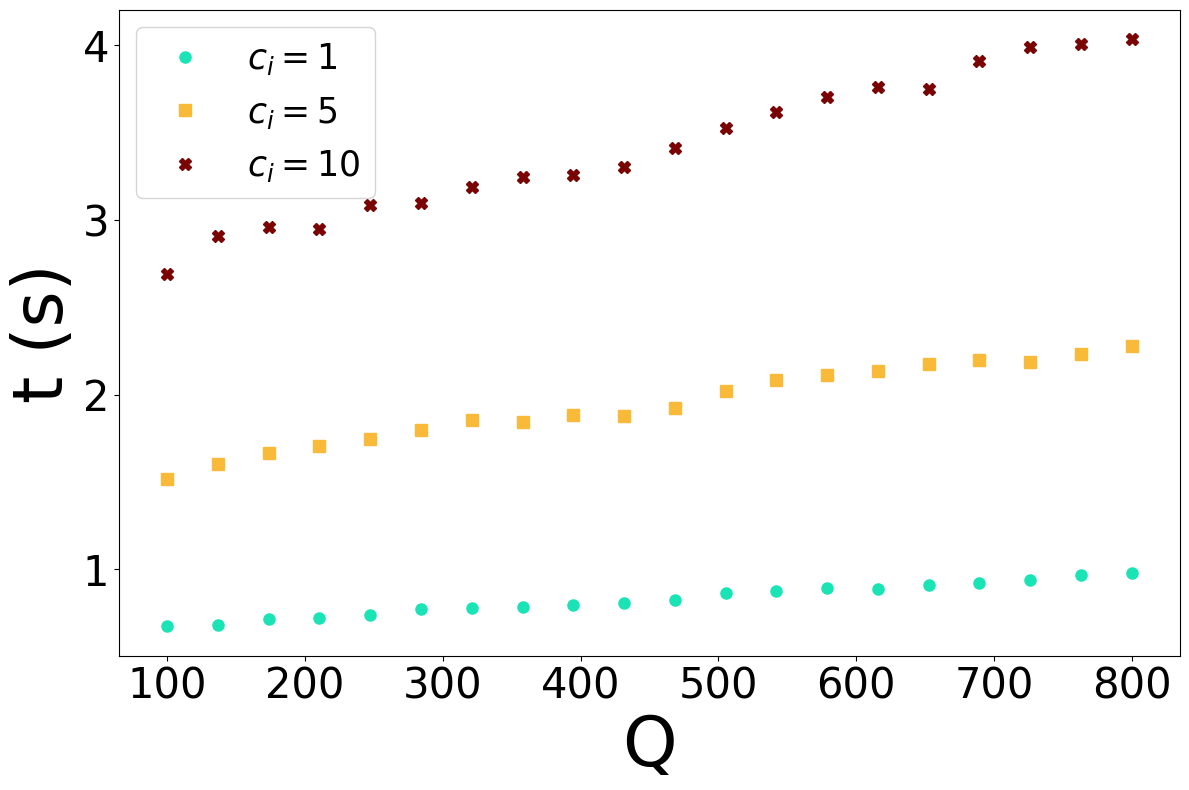

In [31]:
import numpy as np
### Extraer los datos generados en el knapsack 0-1 optimizado
filename = "datos del 0-1 optimizado del knapsack_tiempo capacidad.txt"
# Leer el archivo y extraer arrays
medias = []

with open(filename, 'r') as file:
    lines = file.readlines()
    # Extraemos las líneas específicas
    for i, line in enumerate(lines):
        if "medias de tiempos:" in line:
            medias = list(map(float, lines[i + 1].strip().split(", ")))  # Cambiado a float
        if "capacidad:" in line:
            capacidad_opti = list(map(float, lines[i + 1].strip().split(", ")))  # Cambiado a float

cmap = plt.cm.turbo
gradient = np.linspace(0, 1, 4)
#plot_function(capacidad_opti, medias, "Q", "t (s)",titulo="capacity-time_159.pdf",color='purple', marker='P', etiqueta=r"$c_i=1$ optimizado")
plot_function(capacidades[0], tiempos[0], "Q", "t (s)",titulo="capacity-time_159.pdf", color=cmap(gradient[1]), etiqueta=r"$c_i=1$")
plot_function(capacidades[1], tiempos[1], "Q", "t (s)",titulo="capacity-time_159.pdf",color=cmap(gradient[2]), marker='s', etiqueta=r"$c_i=5$")
plot_function(capacidades[2], tiempos[2], "Q", "t (s)",titulo="capacity-time_159.pdf",color=cmap(gradient[3]), marker='X', etiqueta=r"$c_i=10$")


# Dependencia entre el tiempo y el numero de clases

In [ ]:
def expe_clases_tiempo(c_i: list, max_capacity, n_inter,n_clases_max):
    """_summary_

    Args:
        c_i (list): lista que contiene el numero de elementos de los experimentos a realizar
        max_capacity (_type_): capacidad maxima a introducir en cada experimento
        n_inter (_type_): numero de puntos de cada experimento
        n_clases_max (_type_): maximo numero de clases

    Returns:
       tiempos: media de los tiempos entre las 10 veces que se ha repetido el experimento
       num_clases: lista con las clases utilizadas en los experimentos
    """
    # magic number
    Experiment_repetition = 10
    Num_Clases_umbral = 100

    # resultados
    tiempos=[]
    num_clases=[]
    clases = np.linspace(Num_Clases_umbral,n_clases_max,n_inter)
    clases = np.round(clases)
    tau=1
    for n_elementos_ci in c_i:
        clas = []
        tiempo_total = []
        for iter in range(Experiment_repetition):
            time_t=[]
            for clase in clases:
                clase = int(clase)
                pesos = np.random.randint(1,Experiment_repetition,clase)
                valores = np.random.rand(clase)
                n_elementos = [n_elementos_ci]*clase
                if iter==0:
                    clas.append(clase)
                inicio=time()
                solution=solver(pesos,valores,n_elementos,int(max_capacity),tau)
                time_t.append(time()-inicio)
            tiempo_total.append(time_t)
        tiempos.append(tiempo_total)
        num_clases.append(clas)
        
    # Media de los experimentos    
        i=0
    for tiempo in tiempos:
        tiempos[int(i)] = media_por_posicion(tiempo)
        i=i+1
    return tiempos, num_clases

    

In [ ]:
tiempos_cl, num_clases_total_cl = expe_clases_tiempo([1,5,10],1500,20,1000)

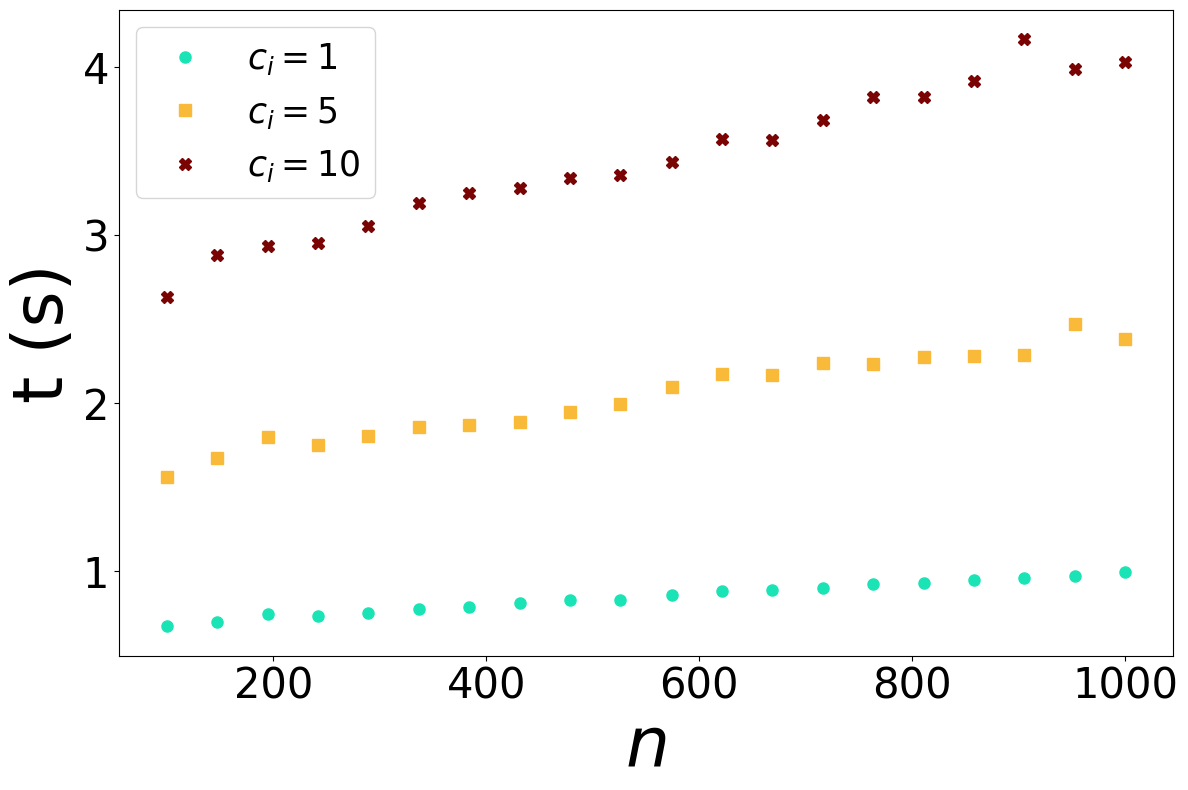

In [ ]:
### Extraer los datos generados en el knapsack 0-1 optimizado
filename = "datos del 0-1 optimizado del knapsack_tiempo-num_clases.txt"
# Leer el archivo y extraer arrays
medias = []

with open(filename, 'r') as file:
    lines = file.readlines()
    # Extraemos las líneas específicas
    for i, line in enumerate(lines):
        if "medias de tiempos:" in line:
            tiempos_opt = list(map(float, lines[i + 1].strip().split(", ")))  # Cambiado a float
        if "num_clases:" in line:
            num_clases_opt = list(map(float, lines[i + 1].strip().split(", ")))  # Cambiado a float

cmap = plt.cm.turbo
gradient = np.linspace(0, 1, 4)
# Ploteo de los experimentos realizados
#plot_function(num_clases_opt, tiempos_opt, r"$n$", "t (s)",titulo="clases-time_159.pdf", color = cmap(gradient[0]), marker='P', etiqueta=r"$c_i=1$ optimizado")
plot_function(num_clases_total_cl[0], tiempos_cl[0], r"$n$", "t (s)",titulo="clases-time.pdf", color = cmap(gradient[1]), etiqueta=r"$c_i=1$")
plot_function(num_clases_total_cl[1], tiempos_cl[1], r"$n$", "t (s)",titulo="clases-time.pdf", marker='s', color = cmap(gradient[2]),  etiqueta=r"$c_i=5$")
plot_function(num_clases_total_cl[2], tiempos_cl[2], r"$n$", "t (s)",titulo="clases-time.pdf", marker='X',color = cmap(gradient[3]),  etiqueta=r"$c_i=10$")


In [ ]:
plt.clear()